### **Food Vision 101: Multi-Class Food Classification with EfficientNetB0**

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
!pip install wandb

In [27]:
import os
import matplotlib.pyplot as plt
from pathlib import Path
import pandas as pd
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
from tensorflow.keras.models import load_model
import wandb
from wandb.integration.keras import WandbMetricsLogger
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
import seaborn as sns
import plotly.express as px

In [7]:
dataset_path = Path("/content/drive/MyDrive/Dataset/101_food_classes_10_percent")

train_path = dataset_path / "train"
test_path = dataset_path / "test"

In [16]:
class_names = sorted([folder.name for folder in train_path.iterdir() if folder.is_dir()])

print(f"Total Classes: {len(class_names)}\n")
print("Food Classes:")
print("-" * 40)
for i, class_name in enumerate(class_names, start=1):
    print(f"{i}. {class_name}")
print("-" * 40)

Total Classes: 101

Food Classes:
----------------------------------------
1. apple_pie
2. baby_back_ribs
3. baklava
4. beef_carpaccio
5. beef_tartare
6. beet_salad
7. beignets
8. bibimbap
9. bread_pudding
10. breakfast_burrito
11. bruschetta
12. caesar_salad
13. cannoli
14. caprese_salad
15. carrot_cake
16. ceviche
17. cheese_plate
18. cheesecake
19. chicken_curry
20. chicken_quesadilla
21. chicken_wings
22. chocolate_cake
23. chocolate_mousse
24. churros
25. clam_chowder
26. club_sandwich
27. crab_cakes
28. creme_brulee
29. croque_madame
30. cup_cakes
31. deviled_eggs
32. donuts
33. dumplings
34. edamame
35. eggs_benedict
36. escargots
37. falafel
38. filet_mignon
39. fish_and_chips
40. foie_gras
41. french_fries
42. french_onion_soup
43. french_toast
44. fried_calamari
45. fried_rice
46. frozen_yogurt
47. garlic_bread
48. gnocchi
49. greek_salad
50. grilled_cheese_sandwich
51. grilled_salmon
52. guacamole
53. gyoza
54. hamburger
55. hot_and_sour_soup
56. hot_dog
57. huevos_rancheros

In [ ]:
def count_images_in_folder(folder_path):
    return {folder.name: len(list(folder.glob("*.jpg"))) for folder in folder_path.iterdir() if folder.is_dir()}

train_images_per_class = count_images_in_folder(train_path)
test_images_per_class = count_images_in_folder(test_path)

total_train_images = sum(train_images_per_class.values())
total_test_images = sum(test_images_per_class.values())

# Convert to DataFrame for better visualization
df_train = pd.DataFrame(list(train_images_per_class.items()), columns=["Class", "Train Images"])
df_test = pd.DataFrame(list(test_images_per_class.items()), columns=["Class", "Test Images"])

df_combined = df_train.merge(df_test, on="Class", how="outer").fillna(0)
df_combined = df_combined.sort_values(by=["Train Images", "Test Images"], ascending=False)

# Display dataset statistics
print("=" * 50)
print(f"{'Dataset Statistics':^50}")
print("=" * 50)
print(f"Total Training Images: {total_train_images:,}")
print(f"Total Test Images: {total_test_images:,}\n")
print("Top 10 Classes by Image Count:")
print(df_combined.head(10).to_string(index=False))
print("=" * 50)

                Dataset Statistics                
Total Training Images: 7,582
Total Test Images: 25,260

Top 10 Classes by Image Count:
         Class  Train Images  Test Images
  spring_rolls            82          260
     apple_pie            75          250
baby_back_ribs            75          250
       baklava            75          250
beef_carpaccio            75          250
  beef_tartare            75          250
    beet_salad            75          250
      beignets            75          250
      bibimbap            75          250
 bread_pudding            75          250


In [8]:
IMG_SIZE = (224, 224)
train_data_all_10_percent = tf.keras.preprocessing.image_dataset_from_directory(train_path,
                                                                                label_mode="categorical",
                                                                                image_size=IMG_SIZE)

test_data = tf.keras.preprocessing.image_dataset_from_directory(test_path,
                                                                label_mode="categorical",
                                                                image_size=IMG_SIZE,
                                                                shuffle=False) # don't shuffle test data for prediction analysis

Found 7582 files belonging to 101 classes.
Found 25260 files belonging to 101 classes.


Datatype of training data: <class 'tensorflow.python.data.ops.prefetch_op._PrefetchDataset'>
Batch shape: (32, 224, 224, 3)


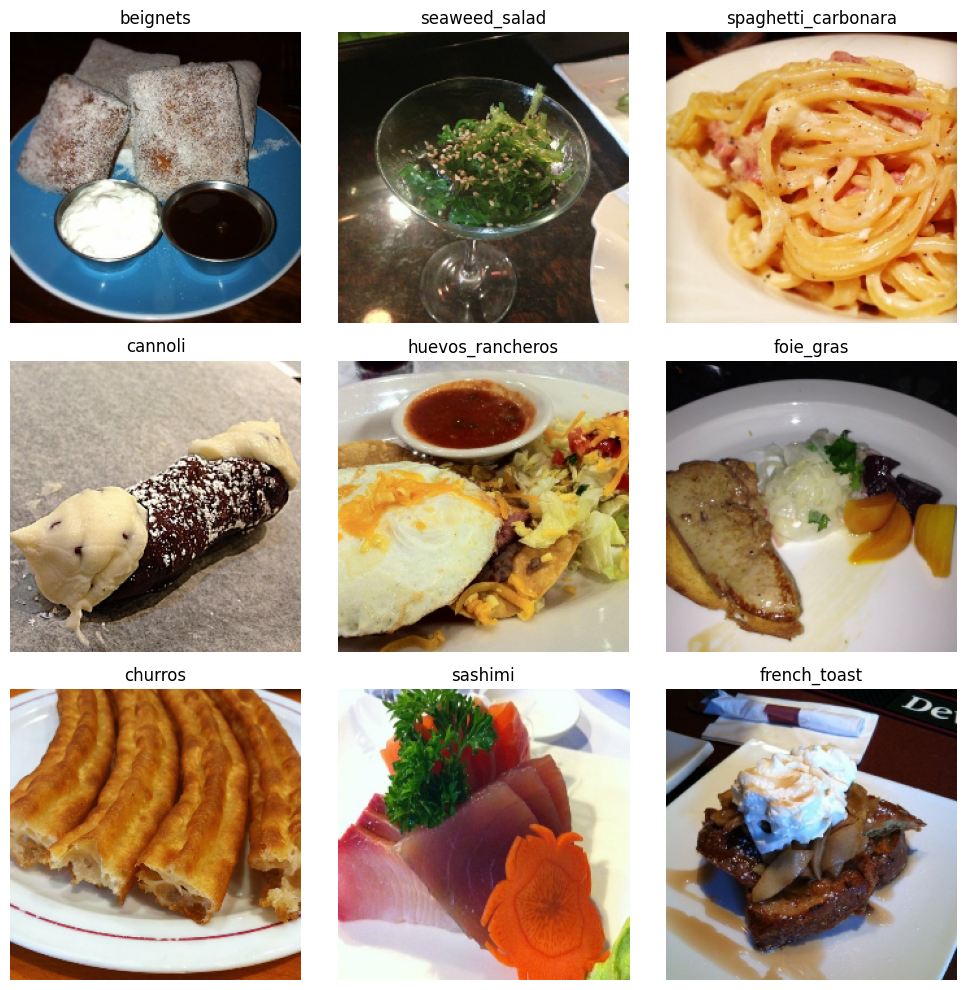

In [ ]:
print(f"Datatype of training data: {type(train_data_all_10_percent)}")

class_names = train_data_all_10_percent.class_names

for images, labels in train_data_all_10_percent.take(1):
    print(f"Batch shape: {images.shape}")

    class_indices = np.argmax(labels, axis=1)

    plt.figure(figsize=(10, 10))
    for i in range(9):
        plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(class_names[class_indices[i]])
        plt.axis("off")
    plt.tight_layout()
    plt.show()

### **Train a model with transfer learning on 10% of 101 food classes**

In [ ]:
wandb.init(
    project="Food Vision 101",
    name="EfficientNetB0_baseline",
    group="Transfer Learning Experiments",
    notes="Baseline model with EfficientNetB0, 10% data, frozen base model.",
    tags=["EfficientNetB0", "baseline", "food-classification"],

    config={
        # Model Parameters
        "architecture": "EfficientNetB0",
        "input_shape": (224, 224, 3),
        "num_classes": len(train_data_all_10_percent.class_names),

        # Training Parameters
        "epochs": 5,
        "batch_size": 32,
        "learning_rate": 0.001,
        "optimizer": "Adam",
        "loss_function": "categorical_crossentropy",
        "metrics": ["accuracy"],

        # Data Augmentation
        "augmentation": {
            "random_flip": "horizontal",
            "random_rotation": 0.2,
            "random_zoom": 0.2,
            "random_height": 0.2,
            "random_width": 0.2
        },

        # Dataset Details
        "dataset": "101_classes_10_percent_data",
        "train_size": len(train_data_all_10_percent),
        "val_size": len(test_data),
        "validation_split": 0.15,

        # Model Checkpointing
        "checkpoint_monitor": "val_accuracy",
        "checkpoint_mode": "max",
        "save_best_only": True,

        # Experiment Tracking
        "run_type": "baseline",
        "experiment_notes": "Testing EfficientNetB0 on 10% dataset with default augmentations.",
})

<IPython.core.display.Javascript object>

wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize
wandb: Paste an API key from your profile and hit enter, or press ctrl+c to quit:

 ··········


wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc
wandb: Currently logged in as: hamzaazharmuhammad (mhamza007) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin
wandb: Using wandb-core as the SDK backend.  Please refer to https://wandb.me/wandb-core for more information.


In [ ]:
checkpoint_path = "101_classes_10_percent_data_model_checkpoint.weights.h5"
checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(checkpoint_path,
                                                         save_weights_only=True, # save only the model weights
                                                         monitor="val_accuracy", # save the model weights which score the best validation accuracy
                                                         save_best_only=True) # only keep the best model weights on file (delete the rest)

In [ ]:
data_augmentation = Sequential([
  layers.RandomFlip("horizontal"),
  layers.RandomRotation(0.2),
  layers.RandomZoom(0.2),
  layers.RandomHeight(0.2),
  layers.RandomWidth(0.2),
  layers.Resizing(224, 224),
  # preprocessing.Rescaling(1./255) # keep for ResNet50V2, remove for EfficientNetB0
], name ="data_augmentation")

In [ ]:
base_model = tf.keras.applications.efficientnet.EfficientNetB0(include_top=False)
base_model.trainable = False

inputs = layers.Input(shape=(224, 224, 3), name="input_layer")
x = data_augmentation(inputs)
x = base_model(x, training=False)
x = layers.GlobalAveragePooling2D(name="global_average_pooling")(x)
outputs = layers.Dense(len(train_data_all_10_percent.class_names), activation="softmax", name="output_layer")(x)
model = tf.keras.Model(inputs, outputs)

16705208/16705208 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [ ]:
model.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)             │ (None, 224, 224, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ data_augmentation (Sequential)       │ (None, 224, 224, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ efficientnetb0 (Functional)          │ (None, 7, 7, 1280)          │       4,049,571 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling               │ (None, 1280)                │               0 │
│ (GlobalAveragePooling2D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ output_layer (Dense)                 │ (None, 101)                 │         129,381 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 4,178,952 (15.94 MB)

 Trainable params: 129,381 (505.39 KB)

 Non-trainable params: 4,049,571 (15.45 MB)

In [ ]:
model.compile(loss="categorical_crossentropy",
              optimizer=tf.keras.optimizers.Adam(),
              metrics=["accuracy"])

history_all_classes_10_percent = model.fit(train_data_all_10_percent,
                                           epochs=5,
                                           validation_data=test_data,
                                           validation_steps=int(0.15 * len(test_data)),
                                           callbacks=[checkpoint_callback, WandbMetricsLogger()])

wandb.finish()

Epoch 1/5
237/237 ━━━━━━━━━━━━━━━━━━━━ 2590s 11s/step - accuracy: 0.1449 - loss: 3.9923 - val_accuracy: 0.4632 - val_loss: 2.5124
Epoch 2/5
237/237 ━━━━━━━━━━━━━━━━━━━━ 49s 206ms/step - accuracy: 0.4656 - loss: 2.4135 - val_accuracy: 0.5183 - val_loss: 2.0456
Epoch 3/5
237/237 ━━━━━━━━━━━━━━━━━━━━ 80s 199ms/step - accuracy: 0.5290 - loss: 2.0042 - val_accuracy: 0.5302 - val_loss: 1.8964
Epoch 4/5
237/237 ━━━━━━━━━━━━━━━━━━━━ 46s 196ms/step - accuracy: 0.5686 - loss: 1.7874 - val_accuracy: 0.5355 - val_loss: 1.8061
Epoch 5/5
237/237 ━━━━━━━━━━━━━━━━━━━━ 86s 214ms/step - accuracy: 0.6059 - loss: 1.5993 - val_accuracy: 0.5548 - val_loss: 1.7234


epoch/accuracy,▁▅▆▇█
epoch/epoch,▁▃▅▆█
epoch/learning_rate,▁▁▁▁▁
epoch/loss,█▄▂▂▁
epoch/val_accuracy,▁▅▆▇█
epoch/val_loss,█▄▃▂▁
epoch/accuracy,0.60472
epoch/epoch,4
epoch/learning_rate,0.001
epoch/loss,1.60442
epoch/val_accuracy,0.55482


In [ ]:
print("🔄 Evaluating model performance on test data...")
results_feature_extraction_model = model.evaluate(test_data)

print("\n✅ Evaluation Complete!")
print("\n📝 Results:\n")
print(f"Test Loss: {results_feature_extraction_model[0]:.4f}")
print(f"Test Accuracy: {results_feature_extraction_model[1]*100:.2f}%")
print("----------------------------------------------------")

🔄 Evaluating model performance on test data...
790/790 ━━━━━━━━━━━━━━━━━━━━ 5236s 7s/step - accuracy: 0.5588 - loss: 1.6904

✅ Evaluation Complete!

📝 Results:

Test Loss: 1.6350
Test Accuracy: 56.90%
----------------------------------------------------


In [6]:
def plot_loss_curves(history):
  loss = history.history['loss']
  val_loss = history.history['val_loss']

  accuracy = history.history['accuracy']
  val_accuracy = history.history['val_accuracy']

  epochs = range(len(history.history['loss']))

  # Plot loss
  plt.plot(epochs, loss, label='training_loss')
  plt.plot(epochs, val_loss, label='val_loss')
  plt.title('Loss')
  plt.xlabel('Epochs')
  plt.legend()

  # Plot accuracy
  plt.figure()
  plt.plot(epochs, accuracy, label='training_accuracy')
  plt.plot(epochs, val_accuracy, label='val_accuracy')
  plt.title('Accuracy')
  plt.xlabel('Epochs')
  plt.legend();

def compare_historys(original_history, new_history, initial_epochs=5):
    acc = original_history.history["accuracy"]
    loss = original_history.history["loss"]

    print(len(acc))

    val_acc = original_history.history["val_accuracy"]
    val_loss = original_history.history["val_loss"]

    total_acc = acc + new_history.history["accuracy"]
    total_loss = loss + new_history.history["loss"]

    total_val_acc = val_acc + new_history.history["val_accuracy"]
    total_val_loss = val_loss + new_history.history["val_loss"]

    print(len(total_acc))
    print(total_acc)

    plt.figure(figsize=(8, 8))
    plt.subplot(2, 1, 1)
    plt.plot(total_acc, label='Training Accuracy')
    plt.plot(total_val_acc, label='Validation Accuracy')
    plt.plot([initial_epochs-1, initial_epochs-1],
              plt.ylim(), label='Start Fine Tuning') # reshift plot around epochs
    plt.legend(loc='lower right')
    plt.title('Training and Validation Accuracy')

    plt.subplot(2, 1, 2)
    plt.plot(total_loss, label='Training Loss')
    plt.plot(total_val_loss, label='Validation Loss')
    plt.plot([initial_epochs-1, initial_epochs-1],
              plt.ylim(), label='Start Fine Tuning') # reshift plot around epochs
    plt.legend(loc='upper right')
    plt.title('Training and Validation Loss')
    plt.xlabel('epoch')
    plt.show()

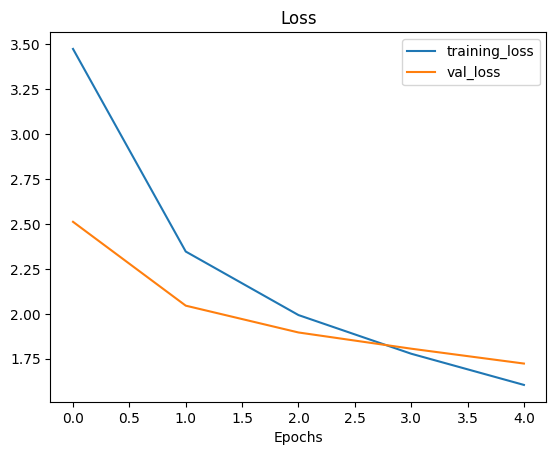

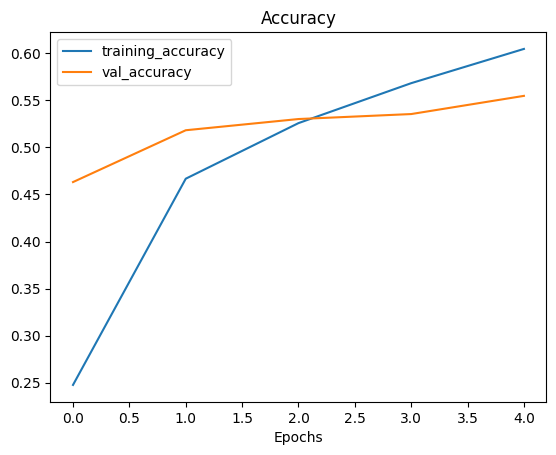

In [ ]:
plot_loss_curves(history_all_classes_10_percent)

### **Fine-tuning**

In [ ]:
wandb.init(
    project="Food Vision 101",
    name="EfficientNetB0_fine_tune",
    group="Transfer Learning Experiments",
    notes="Fine-tuning EfficientNetB0 by unfreezing the last 5 layers, using a lower learning rate.",
    tags=["EfficientNetB0", "fine-tune", "food-classification"],

    config={
        # Model Parameters
        "architecture": "EfficientNetB0",
        "input_shape": (224, 224, 3),
        "num_classes": len(train_data_all_10_percent.class_names),

        # Training Parameters
        "epochs": 10,
        "batch_size": 32,
        "learning_rate": 1e-4,  # Reduced LR for fine-tuning
        "optimizer": "Adam",
        "loss_function": "categorical_crossentropy",
        "metrics": ["accuracy"],

        # Data Augmentation
        "augmentation": {
            "random_flip": "horizontal",
            "random_rotation": 0.2,
            "random_zoom": 0.2,
            "random_height": 0.2,
            "random_width": 0.2
        },

        # Fine-tuning Details
        "base_model_trainable": True,
        "trainable_layers": "Last 5 layers unfrozen",
        "fine_tune_epochs": 10,

        # Dataset Details
        "dataset": "101_classes_10_percent_data",
        "train_size": len(train_data_all_10_percent),
        "val_size": len(test_data),
        "validation_split": 0.15,

        # Experiment Tracking
        "run_type": "fine-tuning",
        "experiment_notes": "Fine-tuning last 5 layers of EfficientNetB0 with a lower learning rate.",
    }
)

In [ ]:
# Unfreeze all of the layers in the base model
base_model.trainable = True

# Refreeze every layer except for the last 5
for layer in base_model.layers[:-5]:
  layer.trainable = False

In [ ]:
model.compile(loss='categorical_crossentropy',
              optimizer=tf.keras.optimizers.Adam(1e-4), # 10x lower learning rate than default
              metrics=['accuracy'])

In [ ]:
# What layers in the model are trainable?
for layer in model.layers:
  print(layer.name, layer.trainable)

input_layer True
data_augmentation True
efficientnetb0 True
global_average_pooling True
output_layer True


In [ ]:
# Check which layers are trainable
for layer_number, layer in enumerate(base_model.layers):
  print(layer_number, layer.name, layer.trainable)

0 input_layer False
1 rescaling False
2 normalization False
3 rescaling_1 False
4 stem_conv_pad False
5 stem_conv False
6 stem_bn False
7 stem_activation False
8 block1a_dwconv False
9 block1a_bn False
10 block1a_activation False
11 block1a_se_squeeze False
12 block1a_se_reshape False
13 block1a_se_reduce False
14 block1a_se_expand False
15 block1a_se_excite False
16 block1a_project_conv False
17 block1a_project_bn False
18 block2a_expand_conv False
19 block2a_expand_bn False
20 block2a_expand_activation False
21 block2a_dwconv_pad False
22 block2a_dwconv False
23 block2a_bn False
24 block2a_activation False
25 block2a_se_squeeze False
26 block2a_se_reshape False
27 block2a_se_reduce False
28 block2a_se_expand False
29 block2a_se_excite False
30 block2a_project_conv False
31 block2a_project_bn False
32 block2b_expand_conv False
33 block2b_expand_bn False
34 block2b_expand_activation False
35 block2b_dwconv False
36 block2b_bn False
37 block2b_activation False
38 block2b_se_squeeze Fals

In [ ]:
# Fine-tune for 5 more epochs
fine_tune_epochs = 10

history_all_classes_10_percent_fine_tune = model.fit(train_data_all_10_percent,
                                                     epochs=fine_tune_epochs,
                                                     validation_data=test_data,
                                                     validation_steps=int(0.15 * len(test_data)), # validate on 15% of the test data
                                                     initial_epoch=history_all_classes_10_percent.epoch[-1], # start from previous last epoch
                                                     callbacks=[WandbMetricsLogger()])

wandb.finish()

Epoch 5/10
237/237 ━━━━━━━━━━━━━━━━━━━━ 65s 225ms/step - accuracy: 0.6100 - loss: 1.6109 - val_accuracy: 0.5659 - val_loss: 1.6930
Epoch 6/10
237/237 ━━━━━━━━━━━━━━━━━━━━ 82s 229ms/step - accuracy: 0.6551 - loss: 1.3966 - val_accuracy: 0.5712 - val_loss: 1.6598
Epoch 7/10
237/237 ━━━━━━━━━━━━━━━━━━━━ 82s 347ms/step - accuracy: 0.6825 - loss: 1.2874 - val_accuracy: 0.5810 - val_loss: 1.6186
Epoch 8/10
237/237 ━━━━━━━━━━━━━━━━━━━━ 140s 340ms/step - accuracy: 0.6975 - loss: 1.2299 - val_accuracy: 0.5797 - val_loss: 1.6132
Epoch 9/10
237/237 ━━━━━━━━━━━━━━━━━━━━ 48s 198ms/step - accuracy: 0.7094 - loss: 1.1811 - val_accuracy: 0.5845 - val_loss: 1.5973
Epoch 10/10
237/237 ━━━━━━━━━━━━━━━━━━━━ 81s 194ms/step - accuracy: 0.7235 - loss: 1.1171 - val_accuracy: 0.5887 - val_loss: 1.5773


epoch/accuracy,▁▃▅▆▇█
epoch/epoch,▁▂▄▅▇█
epoch/learning_rate,▁▁▁▁▁▁
epoch/loss,█▅▄▃▂▁
epoch/val_accuracy,▁▃▆▅▇█
epoch/val_loss,█▆▃▃▂▁
epoch/accuracy,0.72356
epoch/epoch,9
epoch/learning_rate,0.0001
epoch/loss,1.11722
epoch/val_accuracy,0.58872


In [ ]:
print("🔄 Evaluating model performance on test data...")
results_all_classes_10_percent_fine_tune = model.evaluate(test_data)

print("\n✅ Evaluation Complete!")
print("\n📝 Results:\n")
print(f"Test Loss: {results_all_classes_10_percent_fine_tune[0]:.4f}")
print(f"Test Accuracy: {results_all_classes_10_percent_fine_tune[1]*100:.2f}%")
print("----------------------------------------------------")

🔄 Evaluating model performance on test data...
790/790 ━━━━━━━━━━━━━━━━━━━━ 105s 133ms/step - accuracy: 0.5947 - loss: 1.5346

✅ Evaluation Complete!

📝 Results:

Test Loss: 1.4556
Test Accuracy: 61.18%
----------------------------------------------------


5
11
[0.24756000936031342, 0.46676337718963623, 0.5258507132530212, 0.5683196783065796, 0.60472172498703, 0.6256924271583557, 0.6598522663116455, 0.6787127256393433, 0.6987602114677429, 0.7097072005271912, 0.7235558032989502]


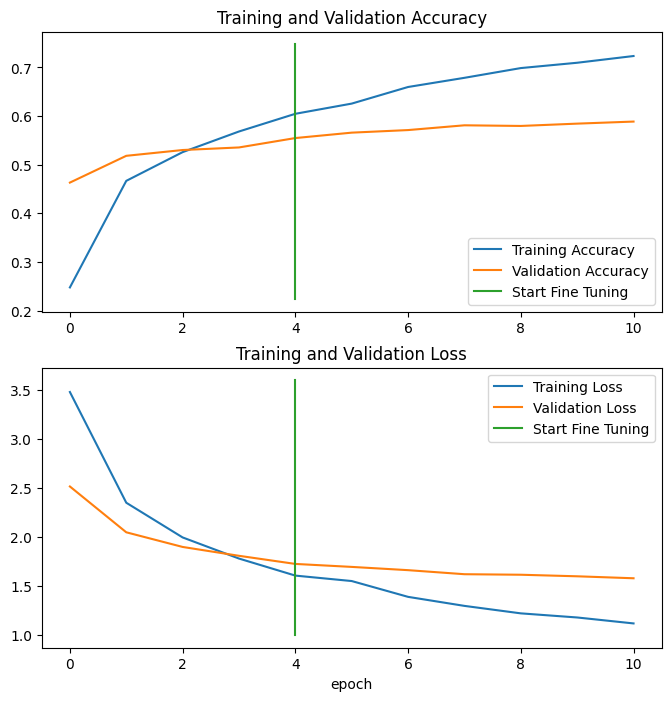

In [ ]:
compare_historys(original_history=history_all_classes_10_percent,
                 new_history=history_all_classes_10_percent_fine_tune,
                 initial_epochs=5)

In [ ]:
model.save("drive/My Drive/Models/Food Vision 101/101_food_class_10_percent_saved_big_dog_model.keras")

### **Evaluating the performance of the model across all different classes**

In [5]:
model_path = '/content/drive/My Drive/Models/Food Vision 101/101_food_class_10_percent_saved_big_dog_model.keras'
model = load_model(model_path)

In [ ]:
print("🔄 Evaluating model performance on test data...")
loaded_loss, loaded_accuracy = model.evaluate(test_data)

print("\n✅ Evaluation Complete!")
print("\n📝 Results:\n")
print(f"Test Loss: {loaded_loss:.4f}")
print(f"Test Accuracy: {loaded_accuracy*100:.2f}%")
print("----------------------------------------------------")

🔄 Evaluating model performance on test data...
790/790 ━━━━━━━━━━━━━━━━━━━━ 109s 132ms/step - accuracy: 0.5947 - loss: 1.5346

✅ Evaluation Complete!

📝 Results:

Test Loss: 1.4556
Test Accuracy: 61.18%
----------------------------------------------------


### **Making predictions with our trained model**

In [9]:
print("Starting prediction...")
pred_probs = model.predict(test_data, verbose=1)
print("Prediction completed!")

print(f"Shape of predictions: {pred_probs.shape}")
print(f"First 5 predictions:\n{pred_probs[:5]}")
print(f"Prediction range: Min={np.min(pred_probs)}, Max={np.max(pred_probs)}")

Starting prediction...
790/790 ━━━━━━━━━━━━━━━━━━━━ 3999s 5s/step
Prediction completed!
Shape of predictions: (25260, 101)
First 5 predictions:
[[3.08587313e-01 3.58639722e-04 3.42244178e-01 1.12485077e-06
  2.35548905e-05 8.28678822e-06 9.24310007e-04 2.15786440e-05
  3.74285318e-02 6.90856250e-04 2.14221982e-05 1.89971597e-05
  2.86114193e-03 2.33217452e-06 4.25217254e-03 1.67002913e-03
  7.33249690e-05 2.23147171e-03 4.79094451e-03 3.52377792e-05
  7.35349837e-04 1.61711025e-04 2.78351596e-04 5.46383497e-04
  1.92611333e-04 3.39779351e-03 1.14593550e-03 2.07939112e-04
  2.31235065e-02 9.78119904e-04 1.12115431e-05 1.09293277e-03
  9.12097632e-04 1.30543158e-05 3.13158566e-03 1.93120632e-05
  4.77451511e-04 2.35736347e-03 2.61933170e-02 1.50524182e-04
  5.72990684e-04 2.13377154e-03 1.46406866e-03 3.82083235e-05
  1.98505368e-04 5.52781712e-05 2.59418576e-03 1.89334867e-04
  2.74638423e-05 2.66710389e-02 1.96853362e-04 4.17488220e-04
  4.52292748e-02 1.52165061e-02 7.98590845e-05 9.3

In [10]:
print(f"Total number of samples predicted: {len(pred_probs)}")
print(f"Number of prediction probabilities for sample 0: {len(pred_probs[0])}")
print(f"Prediction probabilities for sample 0:\n{pred_probs[0]}")
print(f"Class with the highest predicted probability for sample 0: {np.argmax(pred_probs[0])}")

Total number of samples predicted: 25260
Number of prediction probabilities for sample 0: 101
Prediction probabilities for sample 0:
[3.08587313e-01 3.58639722e-04 3.42244178e-01 1.12485077e-06
 2.35548905e-05 8.28678822e-06 9.24310007e-04 2.15786440e-05
 3.74285318e-02 6.90856250e-04 2.14221982e-05 1.89971597e-05
 2.86114193e-03 2.33217452e-06 4.25217254e-03 1.67002913e-03
 7.33249690e-05 2.23147171e-03 4.79094451e-03 3.52377792e-05
 7.35349837e-04 1.61711025e-04 2.78351596e-04 5.46383497e-04
 1.92611333e-04 3.39779351e-03 1.14593550e-03 2.07939112e-04
 2.31235065e-02 9.78119904e-04 1.12115431e-05 1.09293277e-03
 9.12097632e-04 1.30543158e-05 3.13158566e-03 1.93120632e-05
 4.77451511e-04 2.35736347e-03 2.61933170e-02 1.50524182e-04
 5.72990684e-04 2.13377154e-03 1.46406866e-03 3.82083235e-05
 1.98505368e-04 5.52781712e-05 2.59418576e-03 1.89334867e-04
 2.74638423e-05 2.66710389e-02 1.96853362e-04 4.17488220e-04
 4.52292748e-02 1.52165061e-02 7.98590845e-05 9.36521497e-03
 3.60505190e-

In [11]:
pred_classes = np.argmax(pred_probs, axis=1) # Get the class predicitons of each label

if len(pred_classes) > 0:
    print(f"Total predictions made: {len(pred_classes)}")
    print(f"First 10 class predictions: {pred_classes[:10]}")
else:
    print("No class predictions were generated. Please check the model output.")

Total predictions made: 25260
First 10 class predictions: [ 2  0  0 38  8 78 29  0  9  0]


In [13]:
y_labels = []
print("Extracting true labels from test data...")
for images, labels in test_data.unbatch(): # unbatch the test data and get images and labels
  y_labels.append(labels.numpy().argmax()) # append the index which has the largest value (labels are one-hot)

print(f"Total labels extracted: {len(y_labels)}")
print(f"First 10 true labels: {y_labels[:10]}")

Extracting true labels from test data...
Total labels extracted: 25260
First 10 true labels: [0, 0, 0, 0, 0, 0, 0, 0, 0, 0]


### **Evaluating our models predictions**

In [17]:
print("Generating classification report...\n")
print(classification_report(y_labels, pred_classes, target_names=class_names))

Generating classification report...

                         precision    recall  f1-score   support

              apple_pie       0.36      0.22      0.27       250
         baby_back_ribs       0.48      0.77      0.59       250
                baklava       0.63      0.66      0.65       250
         beef_carpaccio       0.80      0.48      0.60       250
           beef_tartare       0.57      0.45      0.50       250
             beet_salad       0.43      0.44      0.44       250
               beignets       0.71      0.82      0.76       250
               bibimbap       0.84      0.78      0.81       250
          bread_pudding       0.26      0.62      0.37       250
      breakfast_burrito       0.39      0.69      0.50       250
             bruschetta       0.52      0.44      0.48       250
           caesar_salad       0.66      0.68      0.67       250
                cannoli       0.68      0.64      0.66       250
          caprese_salad       0.60      0.52      0.

### **"Most Confused" Classes**

In [19]:
cm = confusion_matrix(y_labels, pred_classes)
n_classes = cm.shape[0]

# Find the most confused pairs (off-diagonal)
confused_pairs = []
for i in range(n_classes):
    for j in range(n_classes):
        if i != j:
            confused_pairs.append((i, j, cm[i, j]))

# Sort by highest confusion
confused_pairs_sorted = sorted(confused_pairs, key=lambda x: x[2], reverse=True)[:10]  # Top 10

# Print the top confused classes
for (i, j, count) in confused_pairs_sorted:
    print(f"Class {class_names[i]} often misclassified as {class_names[j]}: {count} times")

Class spaghetti_bolognese often misclassified as spaghetti_carbonara: 55 times
Class apple_pie often misclassified as bread_pudding: 54 times
Class steak often misclassified as filet_mignon: 51 times
Class steak often misclassified as baby_back_ribs: 41 times
Class filet_mignon often misclassified as steak: 36 times
Class pork_chop often misclassified as filet_mignon: 36 times
Class chicken_quesadilla often misclassified as breakfast_burrito: 34 times
Class foie_gras often misclassified as filet_mignon: 34 times
Class fried_rice often misclassified as macaroni_and_cheese: 34 times
Class panna_cotta often misclassified as chocolate_mousse: 31 times


### **Visualize Subsets of Classes**

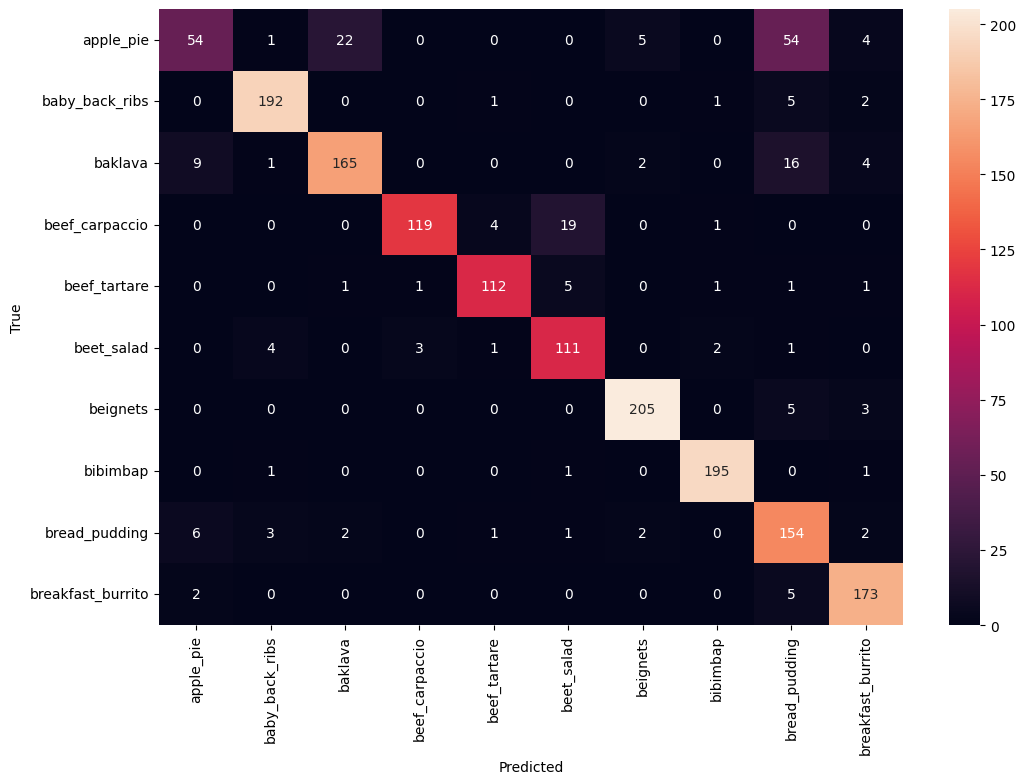

In [21]:
subset_classes = class_names[:10]
subset_cm = cm[:10, :10]

plt.figure(figsize=(12, 8))
sns.heatmap(subset_cm, annot=True, fmt="d", xticklabels=subset_classes, yticklabels=subset_classes)
plt.xlabel("Predicted")
plt.ylabel("True")
plt.show()

In [25]:
fig = px.imshow(cm, x=class_names, y=class_names, color_continuous_scale='Viridis')
fig.update_layout(width=1000, height=1000)
fig.show()

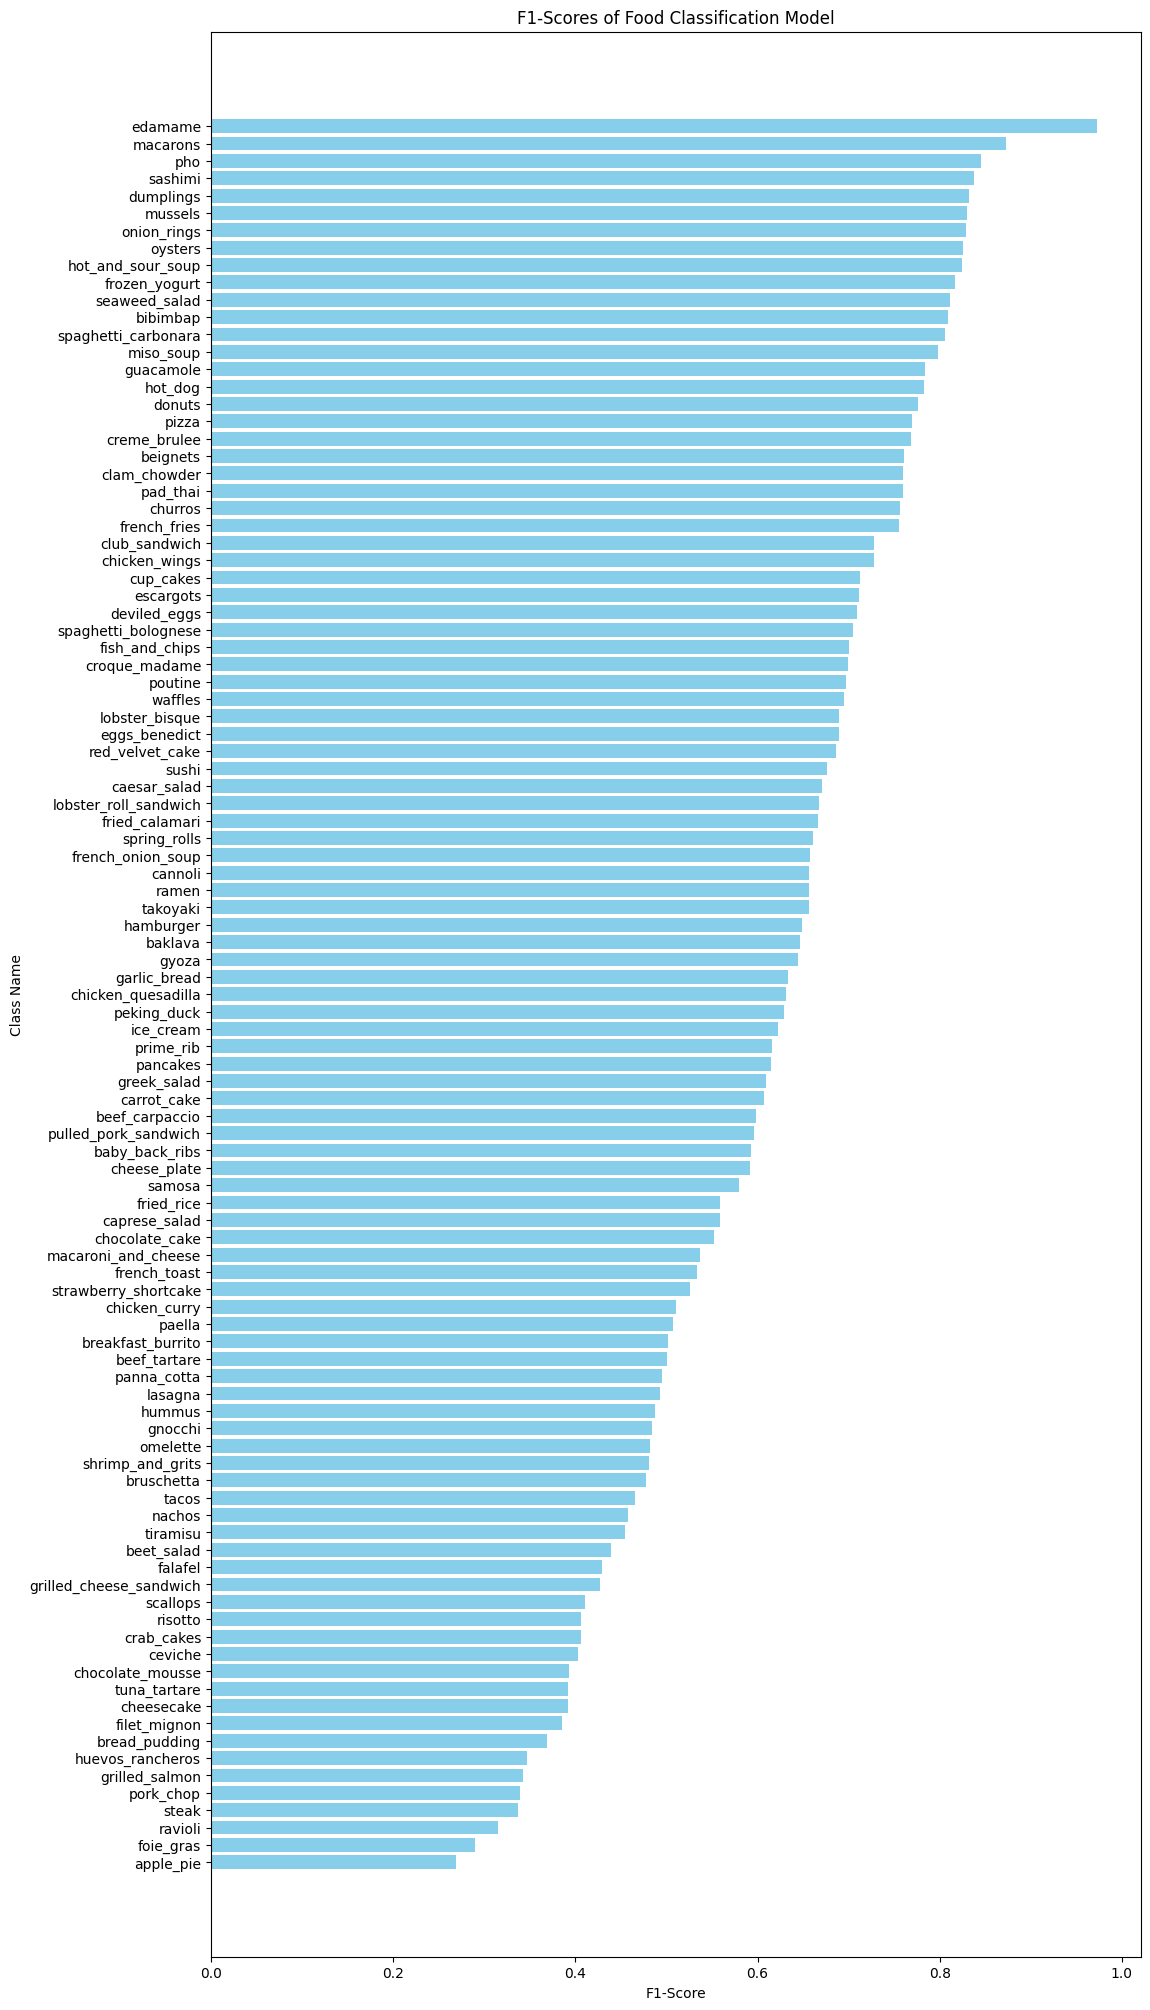

In [31]:
classification_report_dict = classification_report(y_labels, pred_classes, output_dict=True)

# Extract F1 scores
class_f1_scores = {class_names[int(k)]: v["f1-score"]
                   for k, v in classification_report_dict.items() if k.isdigit()}

# Convert to DataFrame and sort
f1_scores = pd.DataFrame({"class_name": class_f1_scores.keys(),
                          "f1-score": class_f1_scores.values()}).sort_values("f1-score", ascending=False)

plt.figure(figsize=(12, 25))
plt.barh(f1_scores["class_name"], f1_scores["f1-score"], color="skyblue")
plt.xlabel("F1-Score")
plt.ylabel("Class Name")
plt.title("F1-Scores of Food Classification Model")
plt.gca().invert_yaxis()  # Reverse order for better readability

plt.show()